In [13]:
import datetime, urllib, re, math, json, requests
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML

# change plot size
plt.rcParams['figure.dpi'] = 200
# change max number of rows to show
pd.set_option('display.max_rows', 300)

try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

In [158]:
#constants

## plotters formats

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cycler import cycler

myFmt = mdates.DateFormatter('%m/%d')
myLocator = mticker.MultipleLocator(7)

default_cycler = (cycler(marker=['.','*','+','s','x']) *
                  cycler(color=['b','g','k','m','y','c','r']) *
                  cycler(linestyle=['-']))

plt.rc('axes', prop_cycle=default_cycler)

# real time data, from a spin of JHU
http://blog.lazd.net/coronadatascraper/

In [295]:
df = pd.read_csv("http://blog.lazd.net/coronadatascraper/data.csv",parse_dates=True)
dataCS =df.set_index(["city","county","state","country"])


#use index slice for more easy/clean access
idx = pd.IndexSlice

IClmns= idx["cases","death","recovered","tested"]


ctrMask = dataCS["cases"] > 1000
dataCS.loc[idx[:,:, :, ctrMask],IClmns]

cases  death  recovered  tested
city county state          country                                      
NaN  NaN    NaN            Germany        3675    NaN       46.0     NaN
                           Italy         17660    NaN     1439.0     NaN
                           Spain          5232    NaN      193.0     NaN
                           Switzerland    1139    NaN        4.0     NaN
            Hubei          China         67786    NaN    51553.0     NaN
            NaN            Iran          11364    NaN     2959.0     NaN
                           Korea, South   7979    NaN      510.0     NaN
            Guangdong      China          1356    NaN     1296.0     NaN
            Henan          China          1273    NaN     1249.0     NaN
            Zhejiang       China          1215    NaN     1197.0     NaN
            Hunan          China          1018    NaN     1005.0     NaN
            Emilia Romagna ITA            2644    NaN       54.0     NaN
            Lombardia      ITA           11685    NaN     1660.0     NaN
            Veneto         ITA            1937    NaN      107.0     NaN

In [296]:
idx = pd.IndexSlice

# must have colons liberally used, firt two colons for city/county and last colon for all columns
#option 1 for access
dataCS.loc[(np.nan, "Los Angeles County", "CA", "USA")]
#option 2 for access, using idx must have colons liberally used, firt two colons for city/county and last colon for all columns
dataCS.loc[idx[:, "San Diego County", "CA", "USA"],IClmns]
print("Total cases in CA : %d (does not match ca row)"%dataCS.loc[idx[:, :, "CA", "USA"],:].sum()["cases"])
display(HTML(dataCS.loc[idx[:, :, "CA", "USA"],IClmns].to_html()))



Total cases in CA : 447 (does not match ca row)


# CDC Data is here:

html --> https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html    
json --> https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json

In [166]:
#using cdc data direclty for the US


url = "https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json"

r = requests.get(url)
jdata =r.json()

# get x/y's
x = jdata["data"]["columns"][0][1:]
X = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in x] # x's
v = jdata["data"]["columns"][1][1:] # v's (new cases fo the day)

# interpolate the zeros, since nearly impossible to have no growth
V = pd.Series(np.array(v).astype('int'))
V[V==0]=np.nan #
V = V.interpolate()
if(0): #check data
    print(list(zip(X,V)))
# Remove fist zeros
offsetZero = V.notna().idxmax()
V = V.values[offsetZero:]
X = X[offsetZero:]    

# convert new cases (v) to cumulative cases(y)
dataCdc = pd.Series(V,X).cumsum()



# john hopkins data base
## gui 

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

## githunb 

https://github.com/CSSEGISandData/COVID-19

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series

In [167]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids
df =df.set_index(["Country/Region","Lat","Long","Province/State"])


df.columns = pd.to_datetime(data.columns,format="%m/%d/%y")

dt = df.columns[-1]
print(dt)
if sum(df[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data = df.drop(columns=dt)
else:
    data = df
#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
euro      = ["Germany","DenMark","France","Italy","Sweden","Switzerland",
             "Spain","Portugal","Belgium","Iceland","Ireland","Netherlands"]
print(noChin)
data.loc["NoChina",np.NaN,np.NaN,np.NaN]=data.loc[(noChin)].sum()    
data.loc[("Europe",np.NaN,np.NaN,np.NaN)]=data.loc[euro].sum()    
# note this is an over-estimate
data.loc[("USAll",np.NaN,np.NaN,np.NaN)]=data.loc["US"].sum()    

data.loc[("ChinaAll",np.NaN,np.NaN,np.NaN)]=data.loc["China"].sum()  



2020-03-14 00:00:00
Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       ...
       'Tunisia', 'Turkey', 'US', 'Ukraine', 'United Arab Emirates',
       'United Kingdom', 'Uruguay', 'Venezuela', 'Vietnam',
       'occupied Palestinian territory'],
      dtype='object', name='Country/Region', length=142)


In [148]:
# create new groups
# dont use string for UR, but the 50 states

northAmer = ["US","Canada","Mexico"],
asia      = ["South Korea","Taiwan","Japan"]   
middleEast=["Iraq","Egypt","Iran"]
countries={ "NoChina":"NoChina",
            "North America":northAmer,
            "Europe":"Europe",            
            "middle east":middleEast,
            "China":"China",
            "South Korea":"South Korea",
            "Japan":"Japan",
            "Italy":"Italy",            
            "South Korea":"Korea, South",
            "US":"US"}


In [149]:

#data.loc["Italy"][dt]
data[dt]# get last row
data[data[dt]>1000].sort_values("Country/Region").iloc[:,-5:]

2020-03-10  2020-03-11  \
Country/Region Lat     Long      Province/State                           
China          27.6104  111.7088 Hunan                 1018        1018   
               29.1832  120.0934 Zhejiang              1215        1215   
               33.8820  113.6140 Henan                 1272        1273   
               30.9756  112.2707 Hubei                67760       67773   
               23.3417  113.4244 Guangdong             1353        1356   
ChinaAll       NaN     NaN       NaN                  80887       80921   
Europe         NaN     NaN       NaN                  16727       21087   
France         46.2276  2.2137   France                1784        2281   
Germany        51.0000  9.0000   NaN                   1457        1908   
Iran           32.0000  53.0000  NaN                   8042        9000   
Italy          43.0000  12.0000  NaN                  10149       12462   
Korea, South   36.0000  128.0000 NaN                   7513        7755   
NoChina        NaN     NaN       NaN                  37705       44944   
Norway         60.4720  8.4689   NaN                    400         598   
Spain          40.0000 -4.0000   NaN                   1695        2277   
Switzerland    46.8182  8.2275   NaN                    491         652   
USAll          NaN     NaN       NaN                    959        1281   
United Kingdom 55.3781 -3.4360   United Kingdom         382         456   

                                                 2020-03-12  2020-03-13  \
Country/Region Lat     Long      Province/State                           
China          27.6104  111.7088 Hunan                 1018        1018   
               29.1832  120.0934 Zhejiang              1215        1215   
               33.8820  113.6140 Henan                 1273        1273   
               30.9756  112.2707 Hubei                67781       67786   
               23.3417  113.4244 Guangdong             1356        1356   
ChinaAll       NaN     NaN       NaN                  80932       80945   
Europe         NaN     NaN       NaN                  21374       33886   
France         46.2276  2.2137   France                2281        3661   
Germany        51.0000  9.0000   NaN                   2078        3675   
Iran           32.0000  53.0000  NaN                  10075       11364   
Italy          43.0000  12.0000  NaN                  12462       17660   
Korea, South   36.0000  128.0000 NaN                   7869        7979   
NoChina        NaN     NaN       NaN                  47411       64248   
Norway         60.4720  8.4689   NaN                    702         996   
Spain          40.0000 -4.0000   NaN                   2277        5232   
Switzerland    46.8182  8.2275   NaN                    652        1139   
USAll          NaN     NaN       NaN                   1663        2179   
United Kingdom 55.3781 -3.4360   United Kingdom         456         798   

                                                 2020-03-14  
Country/Region Lat     Long      Province/State              
China          27.6104  111.7088 Hunan                 1018  
               29.1832  120.0934 Zhejiang              1227  
               33.8820  113.6140 Henan                 1273  
               30.9756  112.2707 Hubei                67790  
               23.3417  113.4244 Guangdong             1356  
ChinaAll       NaN     NaN       NaN                  80977  
Europe         NaN     NaN       NaN                  41035  
France         46.2276  2.2137   France                4469  
Germany        51.0000  9.0000   NaN                   4585  
Iran           32.0000  53.0000  NaN                  12729  
Italy          43.0000  12.0000  NaN                  21157  
Korea, South   36.0000  128.0000 NaN                   8086  
NoChina        NaN     NaN       NaN                  75125  
Norway         60.4720  8.4689   NaN                   1090  
Spain          40.0000 -4.0000   NaN                   

Growth Rate NoChina:1.15
Growth Rate China:1.07
Growth Rate Korea, South:1.12
Growth Rate Europe:1.19


<Figure size 1200x800 with 0 Axes>

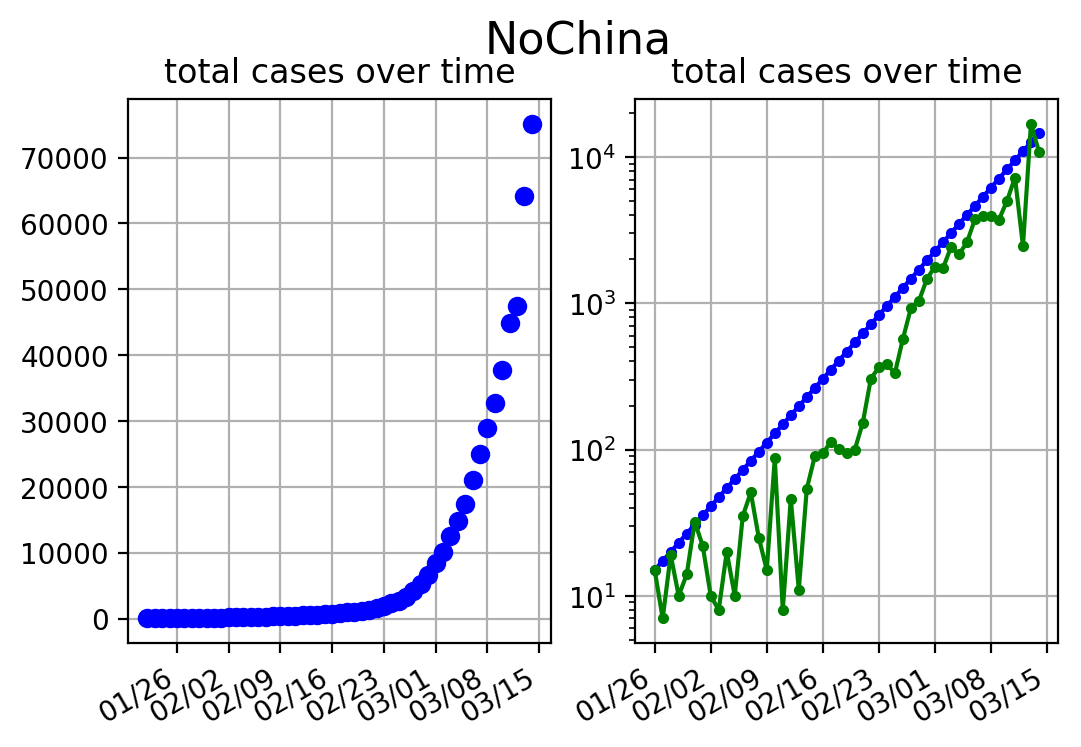

<Figure size 1200x800 with 0 Axes>

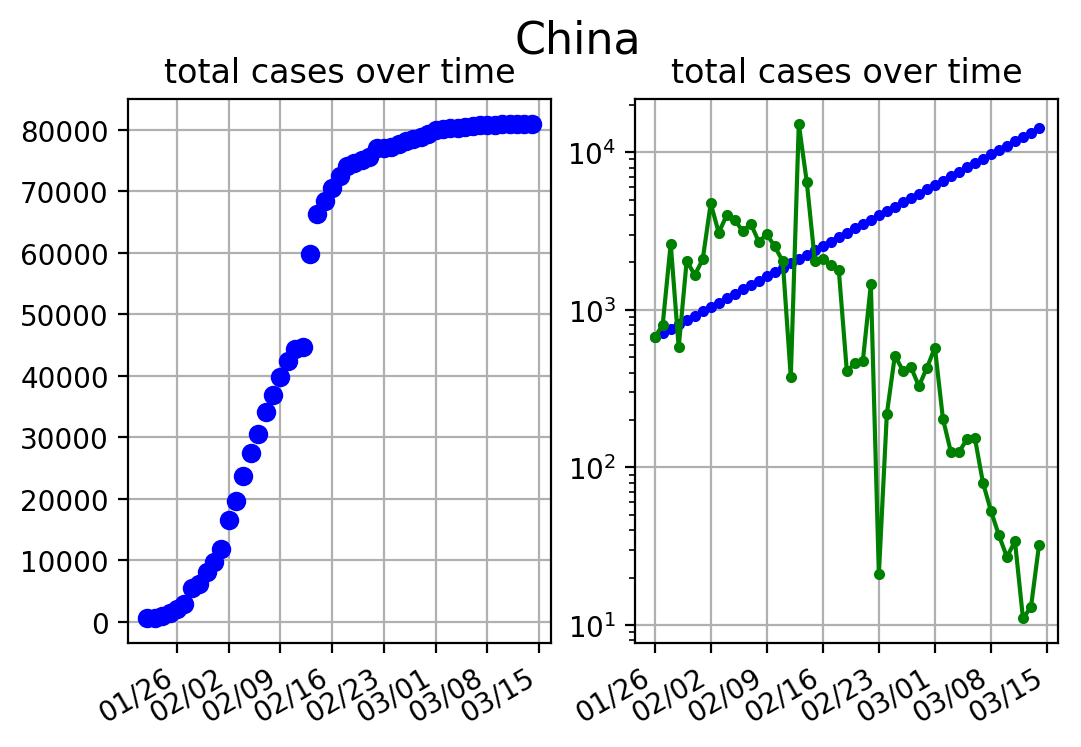

<Figure size 1200x800 with 0 Axes>

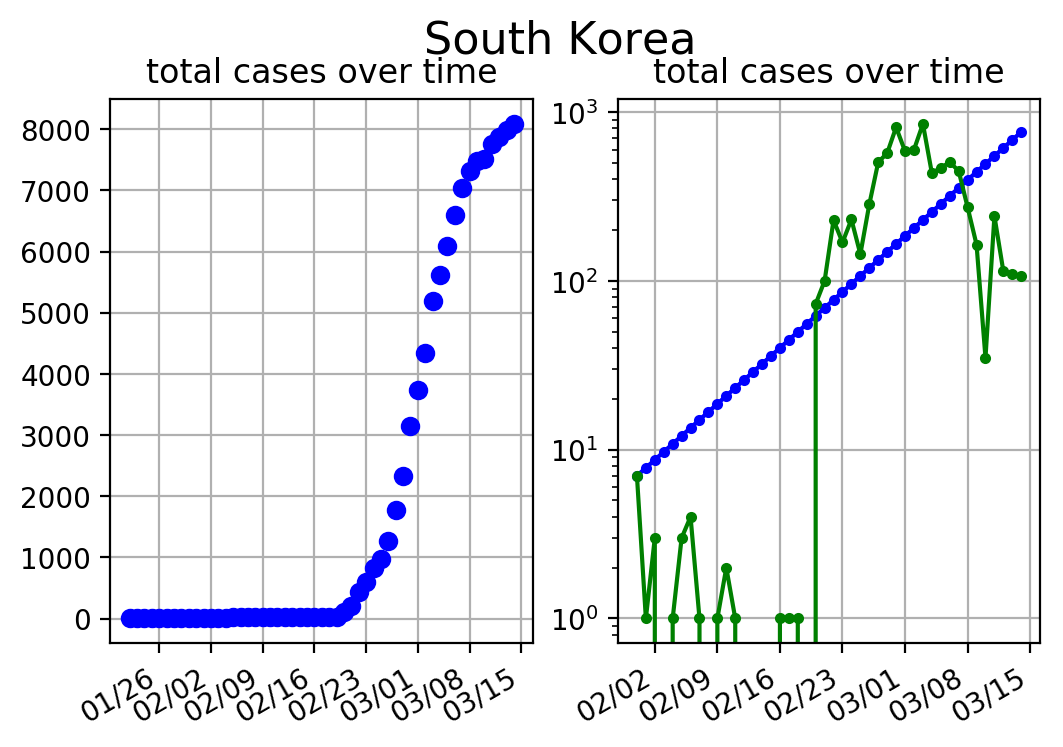

<Figure size 1200x800 with 0 Axes>

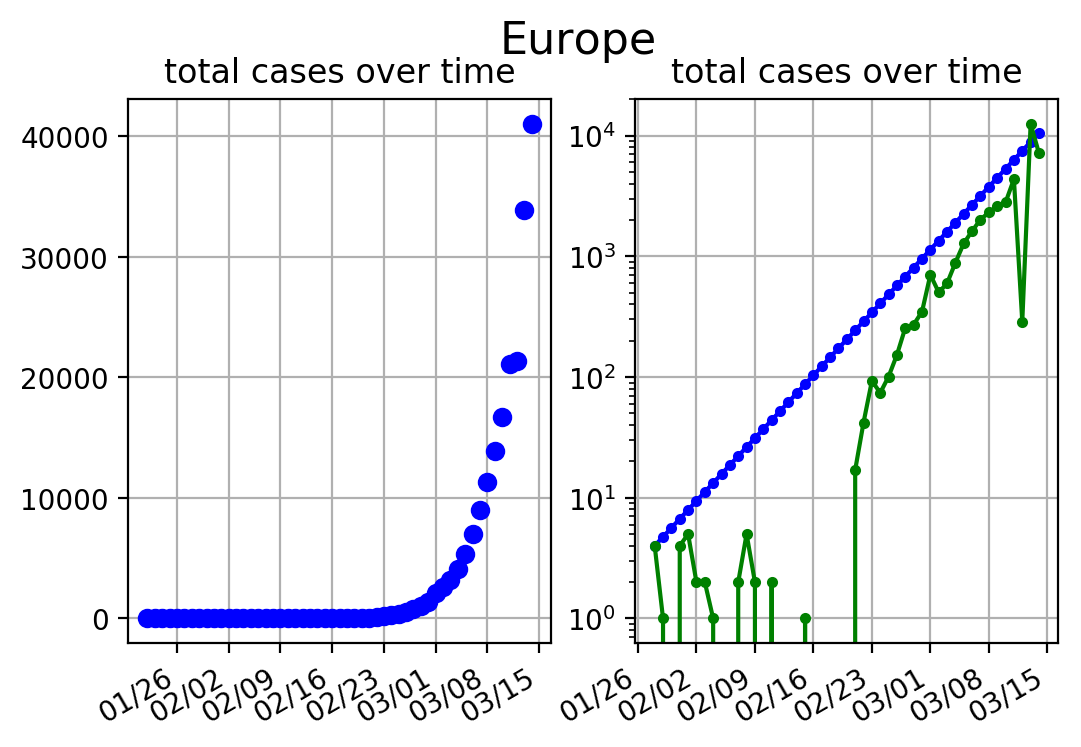

In [168]:
#assume (1+E*P) is 120%


#determine slope and plot
for name in ["NoChina","China", "South Korea", "Europe"]:
    ctr = countries[name]
    plt.figure()
    vals= data.loc[ctr].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    #print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(max(lv)-lv[0])/(sp.size(lv))

    print("Growth Rate %s:%.2f"%(ctr,math.pow(10,m)))
    #print()
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    ax[1].grid()
#    ax[1].legend()
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].set_title("total cases over time");

    fig.autofmt_xdate()
    
    #---
    y=data.loc[ctr].sum()
    ax[0].plot_date(y.index,y.values)        
    ax[0].grid()
#    ax[0].legend()
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].set_title("total cases over time");

    fig.autofmt_xdate()
    
    fig.suptitle('%s'% name, fontsize=16)


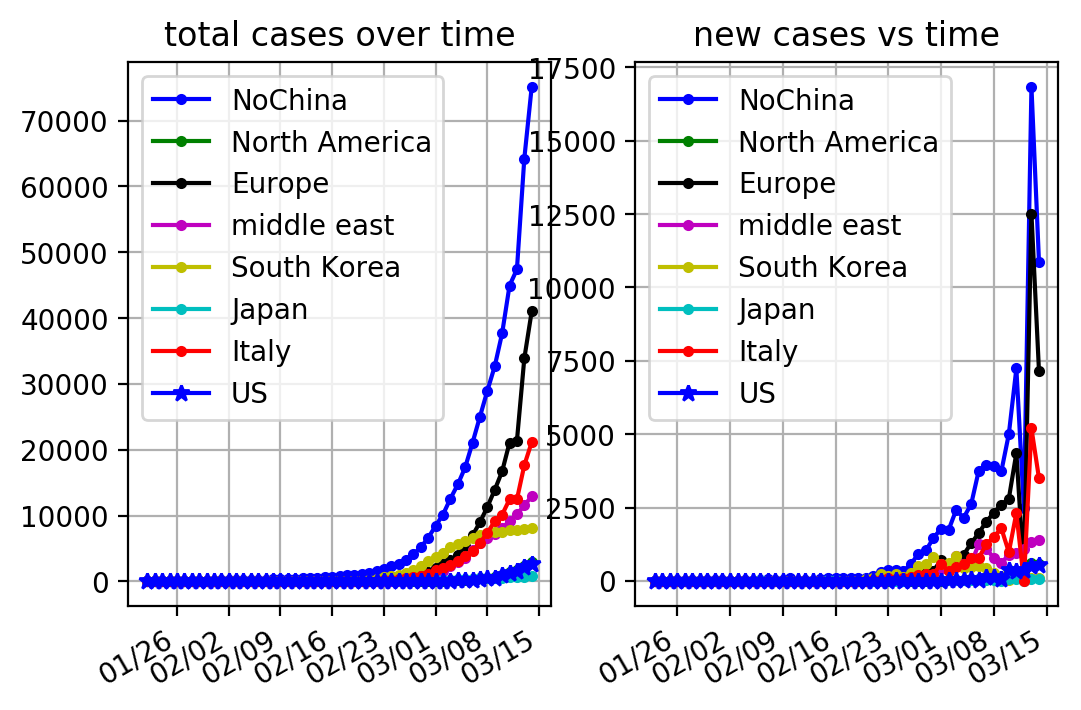

In [169]:

#ignore china here
fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    y = data.loc[(country)].sum()
    ax[0].plot(y.index,y.values,label=name)
#ax[0].xaxis.set_major_locator(myLocator)
ax[0].grid()
ax[0].legend()
ax[0].xaxis.set_major_locator(myLocator)
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    ax[1].plot(vals,label=name)
ax[1].xaxis.set_major_locator(myLocator)
ax[1].grid()
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].legend()
ax[1].set_title("new cases vs time");

fig.autofmt_xdate()



# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

[ The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far. ]


A = the peak infection rate (4600 case/day)

B = the width parameter (0.116)

C = the center date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


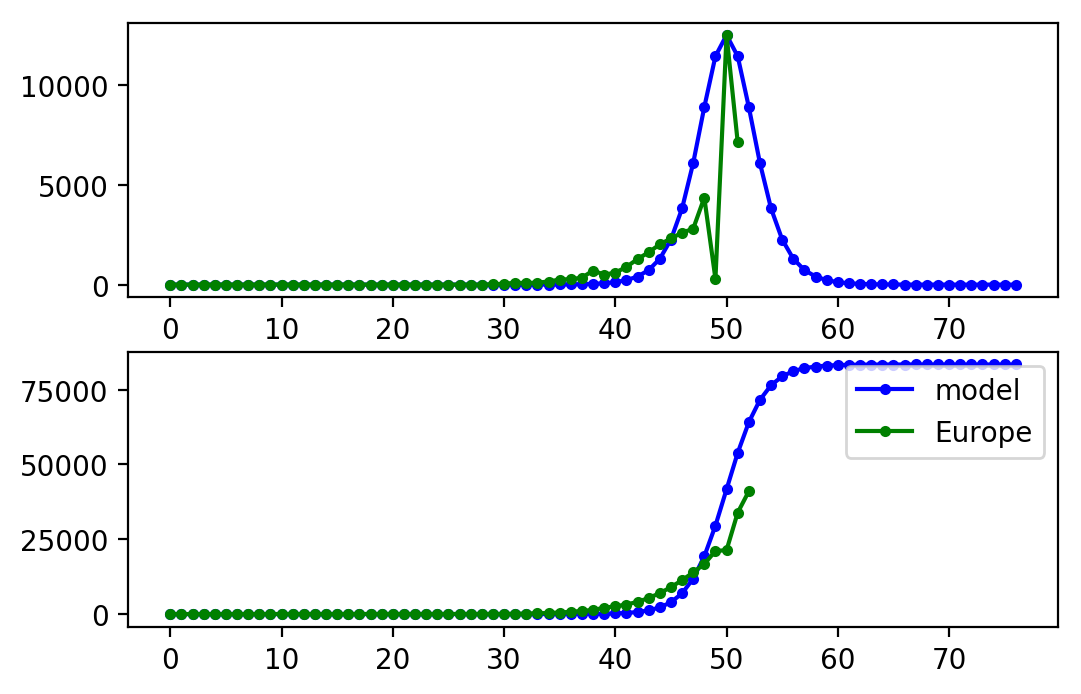

In [175]:

filtV= "South Korea"
filtV= "Europe"

#filtV = "US"
#filtV = "Italy"
#filtV = "China"
for ctr in countries.keys():
    #only get filtered country or group, from countries dict
    if not filtV == ctr: continue
    
    # get daily change, drop first value, '0'
    Nd = data.loc[countries[ctr]].sum().diff().values[1:]
    
    A=max(Nd)
    # this is width variable, smaller means slower groth (this is a guss)
    # first run wiht a good set then adjust to target (for example run with south kora)
    B=0.3

    C=np.argmax(Nd)

    # must be in days

    t = np.arange(0,sp.size(Nd)+25)
    fig, ax = plt.subplots(2,1,)
    ax[0].plot(A/(np.cosh( B * (t-C))**2),label="model")
    ax[0].plot(Nd,label=ctr)
    ax[1].grid()
    ax[1].plot(A/B * ( np.tanh( B * (t-C)) + 1 ),label="model")
    ax[1].plot(data.loc[countries[ctr]].sum().values,label=ctr)
    ax[1].grid()
    plt.legend()
    #plt.title("total cases over time");


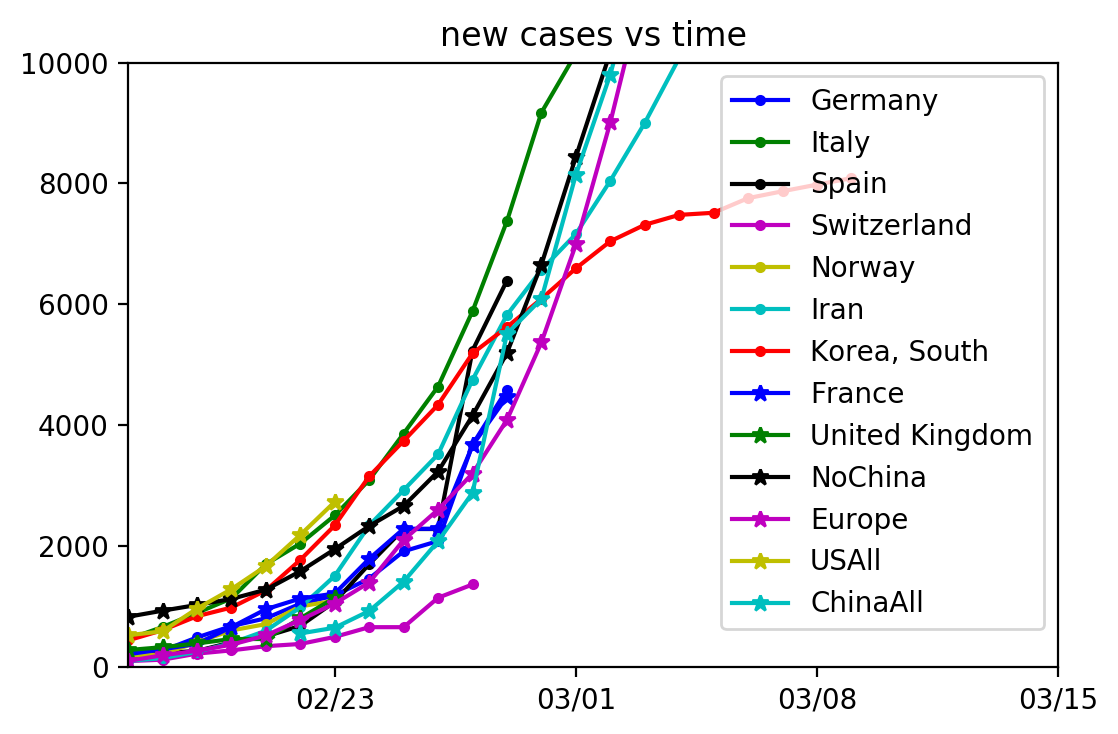

In [218]:
#align countries, with the following offset to get a prediction where they are 
# ideally normalize too

offsets = {"ChinaAll":31,
           "Italy":-9,
           "Spain":-15,
           "Iran":-8,
           "Germany":-15,
           "Korea, South":-5,
           "Switzerland":-16,
           "France":-15,
           "NoChina":0,
           "Europe":-5,
           "Norway":-20,
           "United Kingdom":-20,
           "USAll":-20}


                  


#plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'rgbcmyk') +"
#                                   "cycler('lw', [1, 1, 3])")
                  
fig, ax=plt.subplots(1,1)
for index, row in data[data[dt]>1000].iterrows():
    ctr =index[0]
    #print(ctr)
    if("China" == ctr): continue
    
    vdt = [(d +datetime.timedelta(days=offsets[ctr])).date()#.strftime("%m/%d")
           for d in data.columns]
    
    ax.plot(vdt,row.values, label=ctr)
#ax.xaxis.set_major_locator(myLocator)
ax.grid()
#control range to zoom regio of interest
ax.set_ylim(0, 10000)
ax.set_xlim(datetime.date(2020, 2, 17), datetime.date.today())
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("new cases vs time");



2020-01-22       1
2020-01-23       1
2020-01-24       2
2020-01-25       2
2020-01-26       5
2020-01-27       5
2020-01-28       5
2020-01-29       5
2020-01-30       5
2020-01-31       7
2020-02-01       8
2020-02-02       8
2020-02-03      11
2020-02-04      11
2020-02-05      11
2020-02-06      11
2020-02-07      11
2020-02-08      11
2020-02-09      11
2020-02-10      11
2020-02-11      12
2020-02-12      12
2020-02-13      13
2020-02-14      13
2020-02-15      13
2020-02-16      13
2020-02-17      13
2020-02-18      13
2020-02-19      13
2020-02-20      13
2020-02-21      15
2020-02-22      15
2020-02-23      15
2020-02-24      51
2020-02-25      51
2020-02-26      57
2020-02-27      58
2020-02-28      60
2020-02-29      68
2020-03-01      74
2020-03-02      98
2020-03-03     118
2020-03-04     149
2020-03-05     217
2020-03-06     262
2020-03-07     402
2020-03-08     518
2020-03-09     583
2020-03-10     959
2020-03-11    1281
2020-03-12    1663
2020-03-13    2179
2020-03-14  

Text(0.5, 1.0, 'projection')

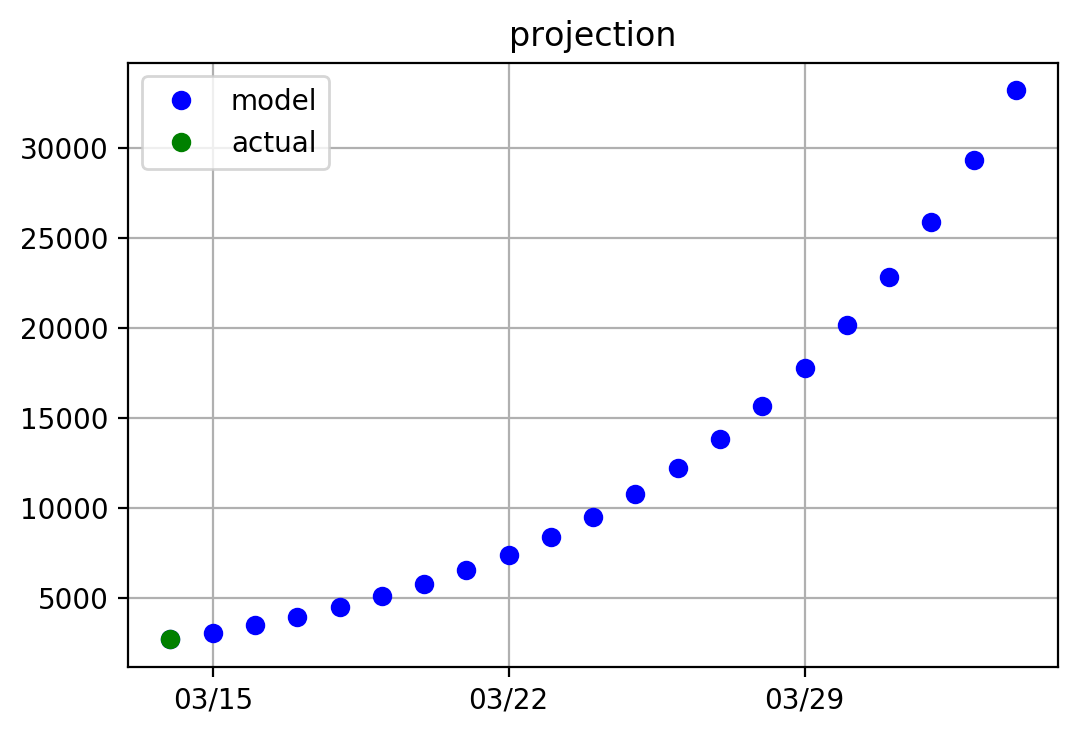

In [354]:
# try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)

# assuming a groth rate of 10%
#where will the us be
#start date
rate      = .125
ctr       = "US"
caseMin   = 300
TN        = 21     # number of intervals after today



s = data.loc[ctr].sum()
print(s)
startDate = s[s>caseMin].index[-1]

print(startDate)

#nmber of intervals
N  = sp.size(data.columns)


# Set the epoch value
Y0 = data[startDate][ctr].sum()
#determine time offset
offset = (data.columns[-1]-startDate).days
Yt =Y0 * sp.exp(rate * np.arange(0,offset + TN))

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,offset + TN)]
NE = (datetime.datetime.today()-data.columns[-1] ).days


fig,ax = plt.subplots(1,1)
ax.plot_date(x,
             Yt,
             label="model")



ax.plot_date(x[:(offset+NE)],
             data.loc[ctr,startDate:].sum(),
             label="actual")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("projection")


s = data.loc[ctr].sum()
print(s)
startDate = s[s>caseMin].index[-1]


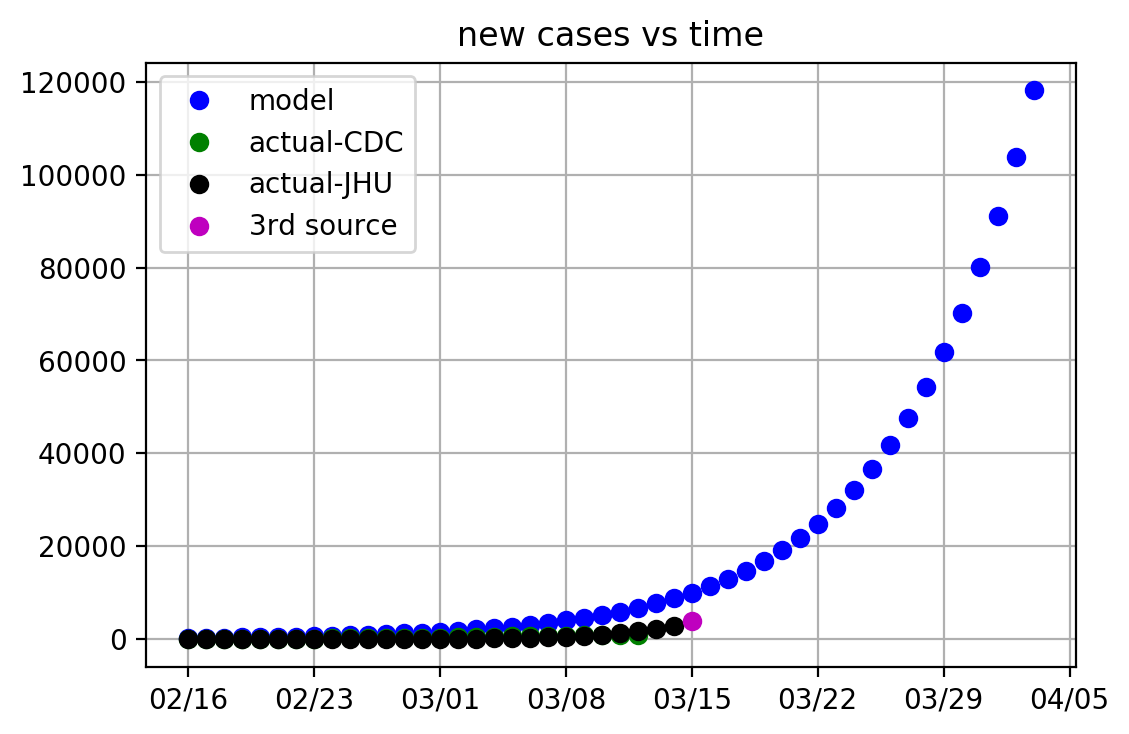

In [307]:
 #try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# use JHU
# estimate US data

idx = pd.IndexSlice

#find cumulateive greater then 50, this will be y0
startDate = dataCdc[dataCdc>50].index[0]
rate = .13

#start from scratch take y[0] and assume X% groth and assume, y0 was 20% report of all reporting (multiply by 5)
# get number of samples in the data base
N = (datetime.date.today()-startDate).days

#project for another 2 week
NP = 20
NEC = (datetime.date.today()    -dataCdc.index[-1]).days-1
NEJ = (datetime.datetime.today()-data.columns[-1] ).days-1


# project
yh = dataCdc[startDate] * 5 * np.exp(rate * np.arange(0,N+NP))

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)

ax.plot_date(x,
             yh,
             label="model")
ax.plot_date(x[0:(N-NEC)],
             dataCdc[startDate:].values,
             label="actual-CDC")
ax.plot_date(x[0:(N-NEJ)],
             data.loc["US",startDate:].sum().values,
             label="actual-JHU")
ax.plot_date(datetime.date.today(),
             dataCS.loc[idx[:, :, :, "USA"],"cases"].sum(),
            label="3rd source")

ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("model vs observed")


yc = np.concatenate([dataCdc.loc[startDate:].values,
                     np.nan * np.ones(NP+NEC)])


yj = np.concatenate([data.loc["US",startDate:].sum().values,
                    np.nan * np.ones(NP+NEJ)])


if(1):
    df =pd.DataFrame({"model": yh,
                  "cdc"  : yc,
                  "jhu"  : yj},index=x)
    print(df)






In [306]:
#script for scraping HTML sites but does not work on java scripts, need to inspect and find source
import requests
try:
    from bs4 import BeautifulSoup
except ImportError:
    !pip install packaging
    from bs4 import BeautifulSoup


URL = 'https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
#notes on soup are here: https://realpython.com/beautiful-soup-web-scraper-python/
#print(soup.prettify())
#res = soup.find("epi-curve")




In [305]:
# JHNU - usa has a problem cities and states overlap
usStates="""
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
"""

US = usStates.split('\n')[1:-1]
#data.loc[(US)]
sp.size(US)
#usStates.split('\n')[1:-1]
#US = list(set(data.index.levels[3])&set(US))
print(data.loc[("US",slice(None),slice(None),US)].sum()[-1])
print(data.loc["US"].sum()[-1])
#data.filter(like=',',axis=0)
#data.loc["US"]
#data.loc["US"]
#data.loc[("US",slice(None),slice(None), lambda df.: df.index.levels[3].str.contains(','))]


2646
2727
